# TA Nasa 

### Descrição do dataset

* **id:** ID exclusivo para cada asteroide;
* **name:** nome do asteroide dado pela NASA;
* **est_diameter_min:** diâmetro mínimo estimado em km;
* **est_diameter_max:** diâmetro máximo estimado em km;
* **relative_velocity:** velocidade relativa à Terra;
* **miss_distance:** distância perdida em km;
* **orbiting_body:** planeta que o asteroide orbita;
* **sentry_object:** incluído no sentry - um sistema automatizado de monitoramento de colisões?;
* **absolute_magnitude:** descreve a luminosidade intrínseca;
* **hazardous:** feature booleana que mostra se o asteroide é prejudicial ou não.

### Começando

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
ds = pd.read_csv('neo.csv') #leitura do dataset

Lembrando que o dataset em questão já está limpo, então não precisamos nos preocupar com isso. 

### Analisando as features:

Vamos agora tentar analisar as *features* e decidir quais têm influência sobre o *target*.

In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


Vemos acima que *id* e *name* não tem relevância para a analise, ademais, o dataset tem 7 *features* além do *target* *hazardous*. Delas, apenas uma é categórica (*orbiting_body*), uma é *bool* (*sentry_object*) e as demais numéricas.

In [4]:
ds.drop(columns = ["id", "name"], inplace = True)

Vamos primeiro tratar das *features* numéricas:

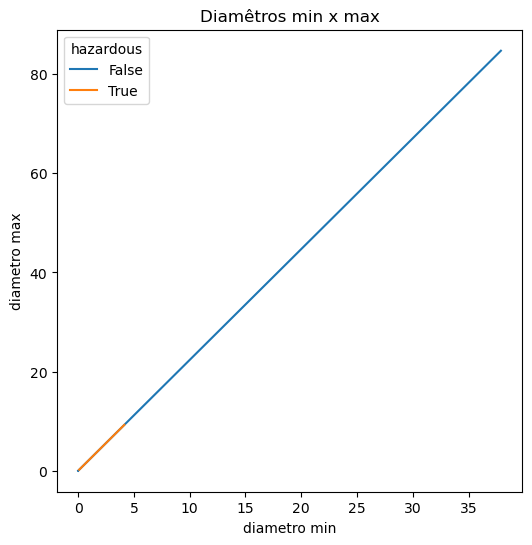

In [5]:
plt.figure(figsize=(6,6))

sns.lineplot(x=ds["est_diameter_min"], y=ds["est_diameter_max"], hue=ds["hazardous"])

plt.title("Diamêtros min x max")
plt.xlabel("diametro min")
plt.ylabel("diametro max")
plt.show()

Vemos acima que há correlação direta entre o tamanho de um asteróide, o que faz sentido intuitivo. Ademais, podemos observar inicialmente que a tendência de asteróides perigosos é que sejam menores. 

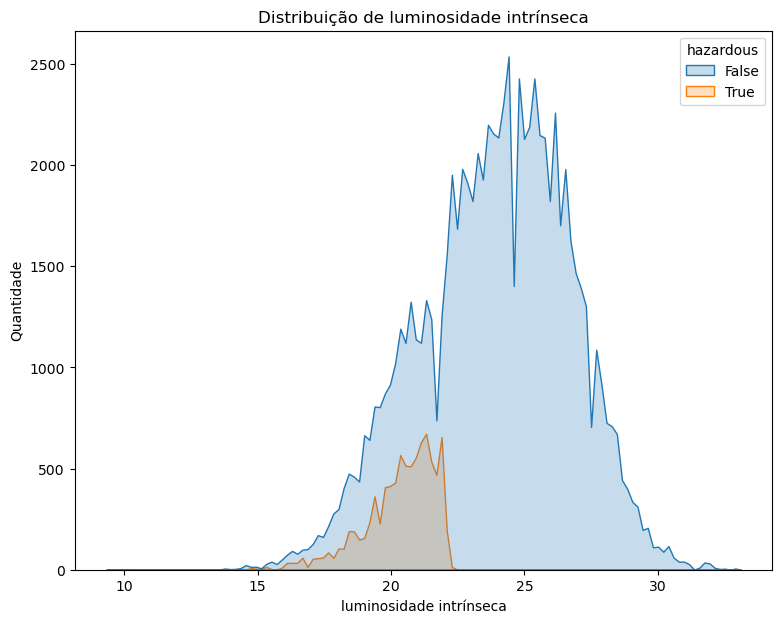

In [6]:
plt.figure(figsize=(9,7))

sns.histplot(ds, x="absolute_magnitude", hue="hazardous", element="poly")

plt.title("Distribuição de luminosidade intrínseca")
plt.xlabel("luminosidade intrínseca")
plt.ylabel("Quantidade")
plt.show()

Observamos acima a *feature* em questão tem influência sobre o *target*, sendo que os asteróides perigosos são aqueles com *absolute_magnitude* cerca de 20-23.

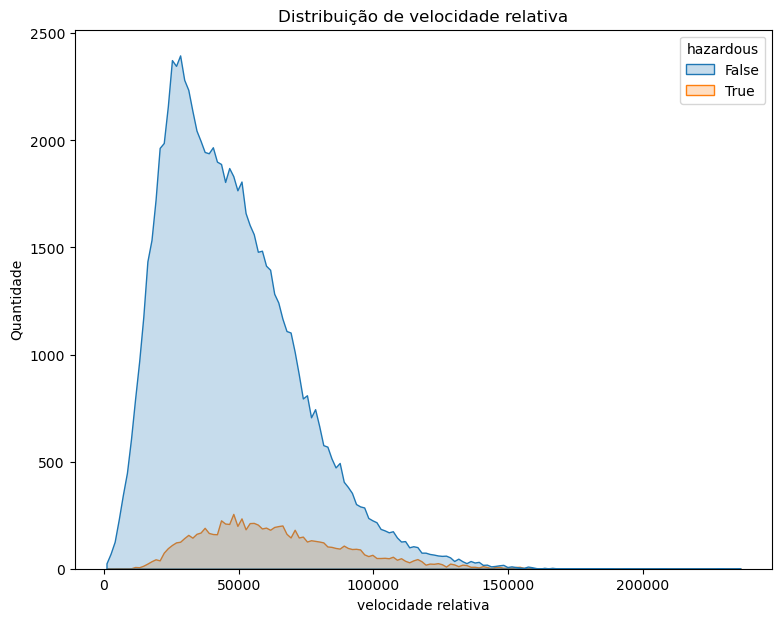

In [7]:
plt.figure(figsize=(9,7))

sns.histplot(ds, x="relative_velocity", hue="hazardous", element="poly")

plt.title("Distribuição de velocidade relativa")
plt.xlabel("velocidade relativa")
plt.ylabel("Quantidade")
plt.show()

Observa-se acima uma distruibuição que cresce rapidamente, se aglomera em torno de 50000 e tem uma cauda que se alonga à direita. Neste caso o *target* parece seguir a tendência geral.

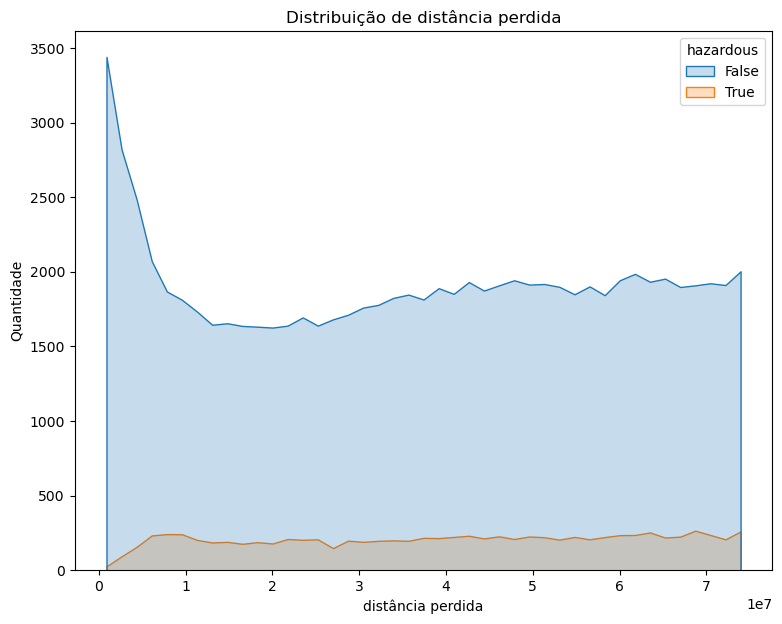

In [8]:
plt.figure(figsize=(9,7))

sns.histplot(ds, x="miss_distance", hue="hazardous", element="poly")

plt.title("Distribuição de distância perdida")
plt.xlabel("distância perdida")
plt.ylabel("Quantidade")
plt.show()

Vemos acima uma distruibuição bastante uniforme. O target também segue tal distribuição, apenas se distoando na faixa acerca de [0~0.7].

Agora vemos olhar para as duas *features*, não numéricas, restantes.

In [9]:
ds['orbiting_body'].value_counts()

Earth    90836
Name: orbiting_body, dtype: int64

Vemos acima que a *feature* tem a mesma entrada para todos os dados, ou seja, pode ser desconsiderado.

In [10]:
ds['sentry_object'].value_counts()

False    90836
Name: sentry_object, dtype: int64

E o mesmo pode ser dito para *sentry_object*.

In [11]:
ds.drop(columns = ["orbiting_body", "sentry_object"], inplace = True)

Para finalizar, vamos olhar o heatmap do dataset para averiguar.

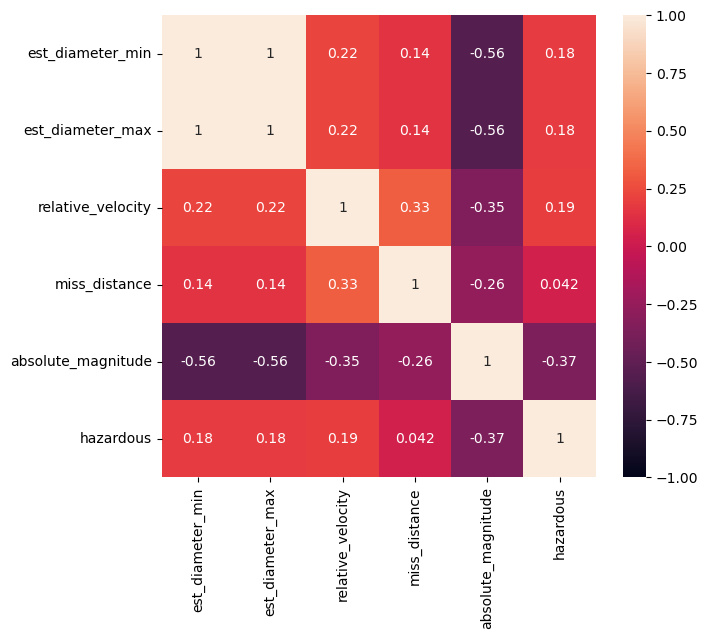

In [12]:
plt.figure(figsize=(7,6))

sns.heatmap(ds.corr(), annot=True, vmin=-1, vmax=1)

plt.show()

Vemos acima, como haviamos suspeitado, há correlação linear entre as *features* de diâmetro, assim, apenas uma delas é necessária (assim economizamos poder computacional). Além disso, vemos que *miss_distance* tem a menor influência sobre o target, mas ainda deve ser considerada.

In [13]:
ds.drop(columns = ["est_diameter_min"], inplace = True)

Em suma, das iniciais 9 colunas que tinhamos inicialmente, terminamos com apenas 4 *features* que serão utilizadas para a predição, sendo a de maior influência *absolute_magnitude*.

## A rede neural

Primeiramente, precisamos criar o set (sem o *target*)

In [14]:
encoded_target = pd.get_dummies(ds['hazardous']) #transformando target bool em valor numérico

dt = ds.drop(columns = ["hazardous"], inplace = True)

Vamos separar os dados em treino e teste:

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = ds
y = encoded_target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size  = 0.25)

Agora sim podemos criar nossa rede neural:

In [17]:
import tensorflow as tf
from tensorflow.keras import layers

In [18]:
model = tf.keras.Sequential()

model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(8, activation = 'relu'))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(2, activation = "sigmoid"))

model.compile(optimizer="sgd", loss="binary_crossentropy", metrics=["accuracy", "AUC"])

In [19]:
results = model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
1065/1065 [==============================] - 3s 2ms/step - loss: 468113260544.0000 - accuracy: 0.9012 - auc: 0.8999
Epoch 2/10
1065/1065 [==============================] - 2s 2ms/step - loss: 0.3493 - accuracy: 0.9026 - auc: 0.9015
Epoch 3/10
1065/1065 [==============================] - 2s 2ms/step - loss: 0.3277 - accuracy: 0.9026 - auc: 0.9019
Epoch 4/10
1065/1065 [==============================] - 1s 1ms/step - loss: 0.3221 - accuracy: 0.9026 - auc: 0.9017
Epoch 5/10
1065/1065 [==============================] - 1s 1ms/step - loss: 0.3203 - accuracy: 0.9026 - auc: 0.9021
Epoch 6/10
1065/1065 [==============================] - 1s 1ms/step - loss: 0.3197 - accuracy: 0.9026 - auc: 0.9027
Epoch 7/10
1065/1065 [==============================] - 1s 1ms/step - loss: 0.3195 - accuracy: 0.9026 - auc: 0.9026
Epoch 8/10
1065/1065 [==============================] - 1s 993us/step - loss: 0.3194 - accuracy: 0.9026 - auc: 0.9024
Epoch 9/10
1065/1065 [==============================] - 1s 

In [20]:
results_score = model.evaluate(X_test, y_test)

710/710 [==============================] - 1s 1ms/step - loss: 0.3187 - accuracy: 0.9029 - auc: 0.9029


## Finalmentes

Como podemos ver, o modelo construido é bastante capaz de prever se um asteróide é perigoso ou não. Temos todas as métricas acima de 90%, o que demonstra boa eficiência (claro que na realidade se tivéssemos que nos preocupar com asteróides se colidindo com a terra isso não seria bom o suficiente, mas para os fins educativos aqui tomados é bastante razoável).